In [2]:
% pylab inline
figsize(10, 8)

import sys
import pickle

sys.path.append("D:/ds/code/implementation")

with open('D:/ds/pickles/allevents_uk2.pkl', 'rb') as file:  
    docs = pickle.load(file)
    
with open('D:/ds/flooding/floods.pkl', 'rb') as file:
    floods = pickle.load(file)
    
with open('D:/ds/code/implementation/real2.pkl', 'rb') as file:
    docs_geo = pickle.load(file)

Populating the interactive namespace from numpy and matplotlib


In [3]:
from datetime import timedelta

# get the min and the maximum date of the events
tmin = min([d['times']['start'] for d in docs]) - timedelta(days=2) 
tmax = max([d['times']['finish'] for d in docs])
tmin, tmax

(datetime.datetime(2015, 12, 6, 16, 0, 0, 423000),
 datetime.datetime(2015, 12, 27, 7, 37, 5, 496000))

In [4]:
# Get the UK polygon 

import sqlite3
from Polygon import Polygon

"""

conn = sqlite3.connect("D:/ds/polydb_2.db")
cursor = conn.cursor()

x = cursor.execute("SELECT poly FROM gadm WHERE n1 = 'England';")

mp = Polygon()
for i in x:
    d = eval(i[0])
    poly = Polygon()
    
    if d['type'] == 'Polygon':
        for c in d['coordinates']:
            poly.addContour(c)
    else:
        for x in d['coordinates']:
            for c in x:
                poly.addContour(c)
    mp += poly
    
with open('ukpoly.pkl', 'wb') as file:
    pickle.dump(mp, file)
    """

with open('ukpoly.pkl', 'rb') as file:
    mp = pickle.load(file)
print("Done")

Done


In [5]:
with open('tweetdistances.pkl', 'rb') as file:
    v = pickle.load(file)
    
distances = v["realdis"]
distances_r = v["randdis"]
distances_r_scaled = v["randscaleddis"]

In [6]:
# Get the events that were within the UK

docs_bd_uk = []
for x in docs:
    do = True
    for p in x['centres']:
        if p is None or not mp.isInside(p[1], p[0]): 
            do = False
            
    if do:
        docs_bd_uk.append(x)
len(docs_bd_uk)

964

In [7]:
# Get the GEO events that were within the UK

docs_geo_bd_uk = []
for x in docs_geo:
    do = True
    for p in x['centres']:
        if p is None or not mp.isInside(p[1], p[0]): 
            do = False
            
    if do:
        docs_geo_bd_uk.append(x)
len(docs_geo_bd_uk)

42

In [90]:
# Load the inferred tweets for the UK

from pymongo import MongoClient

client = MongoClient("localhost", 27017)
db = client["twitter"]
cur = db.ptweets.find({'gotpoly': True})

tweets_uk_real = []
tweets_uk = []
for doc in cur:
    if doc['realgeo'] is not None:
        if mp.isInside(doc['realgeo']['coordinates'][1], doc['realgeo']['coordinates'][0]):
            doc['centre'] = [doc['realgeo']['coordinates'][1], doc['realgeo']['coordinates'][0]]
            tweets_uk_real.append(doc)
            
    if mp.isInside(doc['centre'][0], doc['centre'][1]): 
        tweets_uk.append(doc)
        
    
len(tweets_uk), len(tweets_uk_real)

# tweets_uk = list of tweets within the UK

(244595, 5017)

In [29]:
dis = []
for x in tweets_uk_real:
    v = vincenty((x['realgeo']['coordinates'][0], x['realgeo']['coordinates'][1]), (x['centre'][1], x['centre'][0])).km
    dis.append(v)

median(dis)

0.0

In [8]:
# Load the flood alerts into a dictionary by the day of the alert

from datetime import timedelta, datetime

mnd = datetime(year=tmin.year, month=tmin.month, day=tmin.day) - timedelta(days=1)
mxd = datetime(year=tmax.year, month=tmax.month, day=tmax.day)

windows = {}

curdate = mnd
while curdate <= mxd:
    curdocs = []
    for d in floods:
        if curdate <= d['starttime'] and curdate + timedelta(days=1) > d['starttime']:
            curdocs.append(d)
    windows[str(curdate)] = curdocs
    curdate += timedelta(days=1)
    print(str(curdate), "Alerts =", len(curdocs))
    
flood_warnings_all_uk = []
for d in floods:
    if tmin <= d['starttime'] and tmax > d['starttime']:
        flood_warnings_all_uk.append(d)
# windows = dictionary of flood alerts indexed by their date

2015-12-06 00:00:00 Alerts = 164
2015-12-07 00:00:00 Alerts = 25
2015-12-08 00:00:00 Alerts = 3
2015-12-09 00:00:00 Alerts = 17
2015-12-10 00:00:00 Alerts = 26
2015-12-11 00:00:00 Alerts = 22
2015-12-12 00:00:00 Alerts = 7
2015-12-13 00:00:00 Alerts = 117
2015-12-14 00:00:00 Alerts = 8
2015-12-15 00:00:00 Alerts = 4
2015-12-16 00:00:00 Alerts = 3
2015-12-17 00:00:00 Alerts = 2
2015-12-18 00:00:00 Alerts = 1
2015-12-19 00:00:00 Alerts = 1
2015-12-20 00:00:00 Alerts = 19
2015-12-21 00:00:00 Alerts = 14
2015-12-22 00:00:00 Alerts = 20
2015-12-23 00:00:00 Alerts = 45
2015-12-24 00:00:00 Alerts = 22
2015-12-25 00:00:00 Alerts = 39
2015-12-26 00:00:00 Alerts = 93
2015-12-27 00:00:00 Alerts = 281
2015-12-28 00:00:00 Alerts = 50


In [9]:
# Load the population map and its functions

from eventec import popcount
popmap = popcount.PopMap('D:\ds\population\glds15ag.asc')

xrange = range(600, 850)
yrange = range(4025, 4400)

r_locations = []
r_probabilities = []
count = 0

for y in yrange:
    for x in xrange:
        lat, lon = popmap.get_ll(y, x) 

        if mp.isInside(lat, lon):
            pop = popmap.data[x, y]
            
            if pop == popmap.settings['NODATA_value']:
                continue
            
            r_locations.append((lat, lon))
            r_probabilities.append(pop)
    
    if y % 50 == 0:
        print("Proc row:", y)
print("Done.")

# r_locations = array of lat, lon coordinates within the UK
# r_probabilities = array of populations at corresponding coordinates

(3432, 8640)
Proc row: 4050
Proc row: 4100
Proc row: 4150
Proc row: 4200
Proc row: 4250
Proc row: 4300
Proc row: 4350
Done.


In [30]:
# Get the distances between tweet location and closest flood warnings

from geopy.distance import vincenty

distances = []
for x in tweets_uk:
    p = x['centre']
    
    td = datetime(year=x['timestamp'].year, month=x['timestamp'].month, day=x['timestamp'].day)
    #td2 = datetime(year=x['times']['start'].year, month=x['times']['start'].month, day=x['times']['start'].day - 1)
    warnings = windows[str(td)]# + windows[str(td2)]

    mindis = min([vincenty((w['coordinates'][1], w['coordinates'][0]), (p[1], p[0])).km for w in warnings])
    distances.append(mindis) 

In [31]:
distances_r_scaled = []
distances_r = []

ids = list(range(len(r_locations)))
probs = asarray(r_probabilities) / sum(r_probabilities)

for x in tweets_uk:
    p_s = r_locations[random.choice(ids, p=probs)]
    p = r_locations[random.choice(ids)]

    td = datetime(year=x['timestamp'].year, month=x['timestamp'].month, day=x['timestamp'].day)
    warnings = windows[str(td)]

    mindis_rs = min([vincenty((w['coordinates'][1], w['coordinates'][0]), (p_s[1], p_s[0])).km for w in warnings])
    distances_r_scaled.append(mindis_rs) 
    
    mindis = min([vincenty((w['coordinates'][1], w['coordinates'][0]), (p[1], p[0])).km for w in warnings])
    distances_r.append(mindis) 

(63.163412815889629, 97.486770939976253)

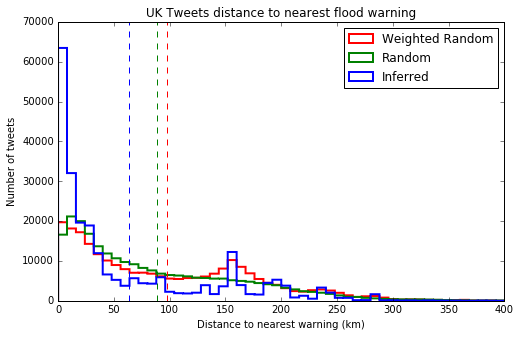

In [110]:
a = hist([distances, distances_r, distances_r_scaled],  histtype='step', bins=50, range=[0, 400], 
         label=["Inferred", "Random", "Weighted Random"], linewidth=2)

axvline(x=mean(distances), linestyle='dashed', color='b')
axvline(x=mean(distances_r), linestyle='dashed', color='g')
axvline(x=mean(distances_r_scaled), linestyle='dashed', color='r')

figsize(8, 5)
legend()
xlabel('Distance to nearest warning (km)')
ylabel('Number of tweets')
title('UK Tweets distance to nearest flood warning')
savefig('uk-tweet-dis', dpi=200)

mean(distances), mean(distances_r_scaled)

In [96]:
from pymongo import MongoClient

# connect to mongodb
client2 = MongoClient("localhost", 27017)
db2 = client["twitter"]

usernames = []
for d in tweets_uk_real:
    x = db2.inftweets.find_one({'_id': d['tweetid']}, {'user.screen_name': 1})
    usernames.append(x['user']['screen_name'])
print("Done.")

Done.


In [97]:
usernames_all = []
for d in tweets_uk:
    x = db2.inftweets.find_one({'_id': d['tweetid']}, {'user.screen_name': 1})
    usernames_all.append(x['user']['screen_name'])
print("Done.")

Done.


In [98]:
from collections import defaultdict
userdict = defaultdict(int)

for x in usernames:
    userdict[x] += 1
    
len(usernames), sorted(userdict.items(), key=lambda x: x[1], reverse=True)

(5017,
 [('RiverlevelsUK', 3763),
  ('FloodAlerts', 397),
  ('DailyCUMBRIA', 139),
  ('BaySARteam', 83),
  ('CumbriaTravel', 61),
  ('northyorktravel', 47),
  ('WestYorksTravel', 34),
  ('riverlevel_0905', 34),
  ('trendinaliaGB', 27),
  ('Dedwards131', 26),
  ('riverlevel_1816', 25),
  ('DaiIyMANCHESTER', 17),
  ('DailySHROPSHIRE', 11),
  ('TyneTravel', 10),
  ('VirtualJukebox', 8),
  ('DailyGLOUCESTER', 7),
  ('DailyCHESHIRE', 6),
  ('SkiptonSC', 5),
  ('fronteratech', 5),
  ('DailyOXFORD', 5),
  ('TeesTravel', 5),
  ('inewsphoto_gbr', 4),
  ('DailySOMERSET', 4),
  ('riverlevel_0069', 4),
  ('DailyDERBYS', 4),
  ('RossJarman', 4),
  ('stuartmoss', 4),
  ('BroccClothing', 4),
  ('AndyMedcalf', 4),
  ('DailyNORFOLK', 4),
  ('VickySander25', 4),
  ('tandleman', 3),
  ('Daily_DEVON', 3),
  ('DailySUFFOLK', 3),
  ('condorchrissy', 3),
  ('maggiehansell52', 3),
  ('tmj_GBR_eng', 3),
  ('CornwaII', 3),
  ('Barnes_James93', 3),
  ('deffmick', 3),
  ('GunnerMoody', 3),
  ('FairTradeCentre', 3

In [106]:
from geopy.distance import vincenty
import datetime

distances_real = []
distances_real_limited = []
for i, x in enumerate(tweets_uk_real):
    p = x['centre']
    
    td = datetime.datetime(year=x['timestamp'].year, month=x['timestamp'].month, day=x['timestamp'].day)
    #td2 = datetime(year=x['times']['start'].year, month=x['times']['start'].month, day=x['times']['start'].day - 1)
    warnings = windows[str(td)]# + windows[str(td2)]

    mindis = min([vincenty((w['coordinates'][1], w['coordinates'][0]), (p[1], p[0])).km for w in warnings])
    distances_real.append(mindis) 
    
    if usernames[i] not in ['RiverlevelsUK', 'FloodAlerts']:
        distances_real_limited.append(mindis)

In [ ]:
distances_no_fluk = [d for i, d in enumerate(distances) if usernames_all[i] not in ['RiverlevelsUK', 'FloodAlerts']]

weights = np.ones_like(distances_no_fluk) / len(distances_no_fluk)
weights2 = np.ones_like(distances_real_limited) / len(distances_real_limited)

a = hist([distances_no_fluk, distances_real_limited],  histtype='step', bins=50, range=[0, 400],
         label=["Inferred Location Tweets", "Real Location Tweets"], linewidth=2, weights=[weights, weights2])

axvline(x=mean(distances), linestyle='dashed', color='b')
axvline(x=mean(distances_real_limited), linestyle='dashed', color='g')

figsize(8, 5)
legend()
xlabel('Distance to nearest warning (km)')
ylabel('Proportion of tweets')
title('UK Tweets distance to nearest flood warning')
savefig('uk-tweet-dis-vsgeo', dpi=200)

In [95]:
distances_no_fluk = [d for i, d in enumerate(distances) if usernames_all[i] not in ['RiverlevelsUK', 'FloodAlerts']]

weights = np.ones_like(distances_no_fluk) / len(distances_no_fluk)
weights2 = np.ones_like(distances_real_limited) / len(distances_real_limited)
weights3 = np.ones_like(distances_r) / len(distances_r)
weights4 = np.ones_like(distances_r_scaled) / len(distances_r_scaled)

a = hist([distances_no_fluk, distances_real_limited, distances_r, distances_r_scaled],  histtype='step', bins=50, range=[0, 400],
         label=["Inferred Location Tweets", "Real Location Tweets", "Random Distribution", "Weighted Random Distribution"], 
         linewidth=2, weights=[weights, weights2, weights3, weights4])

axvline(x=mean(distances_no_fluk), linestyle='dashed', color='b')
axvline(x=mean(distances_real_limited), linestyle='dashed', color='g')
axvline(x=mean(distances_r), linestyle='dashed', color='r')
axvline(x=mean(distances_r_scaled), linestyle='dashed', color='c')

figsize(8, 5)
legend()
xlabel('Distance to nearest warning (km)')
ylabel('Proportion of tweets')
title('UK Tweets distance to nearest flood warning')
savefig('uk-tweet-dis-all', dpi=200)

NameError: name 'usernames_all' is not defined

In [108]:
distances_no_fluk = [d for i, d in enumerate(distances) if usernames_all[i] not in ['RiverlevelsUK', 'FloodAlerts']]
mean(distances_real_limited)

51.847176799094854

In [107]:
len([a for a in distances_no_fluk if a < 20]), len([a for a in distances_real_limited if a < 20]), len(distances_real_limited), len(distances_no_fluk)

(106761, 463, 857, 239943)

In [42]:
v = { "realdis": distances, "randdis": distances_r, "randscaleddis": distances_r_scaled }

with open('tweetdistances.pkl', 'wb') as file:
    pickle.dump(v, file)

AttributeError: 'list' object has no attribute 'set_title'

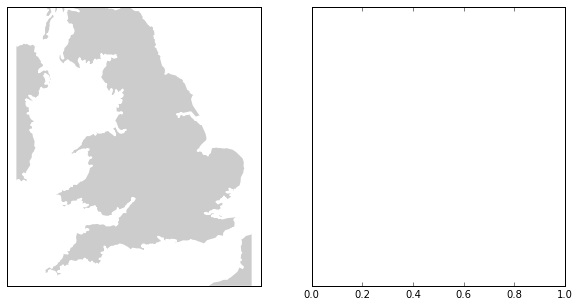

In [92]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon as PolygonMPL
from matplotlib.ticker import LogFormatter 

figsize(10, 5)
f, axarr = plt.subplots(1, 2, sharey=True)

bmp = Basemap(projection='merc', lat_0=53.458736, lon_0=-2.2,
    resolution='i', area_thresh = 1000.0,
    urcrnrlat=56, urcrnrlon=2,
    llcrnrlat=49.75, llcrnrlon=-6.75, ax=axarr[0]) 

c2 = bmp(2, 56)
c1 = bmp(-6.75, 49.75)

bmp.drawcoastlines(color="w", linewidth=2)
#bmp.drawcountries()
bmp.fillcontinents(color='#CCCCCC', zorder=0)
bmp.drawmapboundary()

xp = []
yp = []
cp = []
for x in tweets_uk:
    j = bmp(x['centre'][0], x['centre'][1])
    xp.append(j[0])
    yp.append(j[1])
    cp.append(1/popmap.get_population(x['centre'][1], x['centre'][0]))

ax.set_title('Distribution of flood tweets')
bmp.hexbin(array(xp), array(yp), norm=matplotlib.colors.LogNorm(), gridsize=(30, 20),
          extent=[c2[0], c1[0], c2[1], c1[1]])#C=cp, reduce_C_function=sum)
formatter = LogFormatter(10, labelOnlyBase=False) 
#bmp.colorbar(location='bottom', format=formatter)

###########################

ax = fig.add_subplot(122)
bmp = Basemap(projection='merc', lat_0=53.458736, lon_0=-2.2,
    resolution='i', area_thresh = 1000.0,
    urcrnrlat=56, urcrnrlon=2,
    llcrnrlat=49.75, llcrnrlon=-6.75, ax=axarr[1]) 

bmp.drawcoastlines(color="w", linewidth=2)
#bmp.drawcountries()
bmp.fillcontinents(color='#CCCCCC', zorder=0)
bmp.drawmapboundary()

xp = []
yp = []
for fw in windows.values():
    for w in fw:
        x,y = bmp(w['coordinates'][0],w['coordinates'][1])
        xp.append(x)
        yp.append(y)

ax.set_title('Ditribution of flood warnings')
bmp.hexbin(array(xp), array(yp), norm=matplotlib.colors.LogNorm(), gridsize=(30, 20),
          extent=[c2[0], c1[0], c2[1], c1[1]])
formatter = LogFormatter(10, labelOnlyBase=False) 
#bmp.colorbar(location='bottom', format=formatter)

tight_layout()
plt.savefig('map-points-500k-area.png', dpi=200, alpha=True)

In [89]:
segs = 3
diff = (tmax - tmin) / segs
segmins = [tmin + (i * diff) for i in range(segs)]
segmaxs = [tmin + ((i+1) * diff) for i in range(segs)]

segevs = []
for d in range(segs):
    segevs.append([])
    for x in tweets_uk:
        if (x['timestamp'] >= segmins[d] and x['timestamp'] < segmaxs[d]) or \
            (x['timestamp'] >= segmins[d] and x['timestamp'] < segmaxs[d]):
            segevs[d].append(x)

NameError: name 'tweets_uk' is not defined

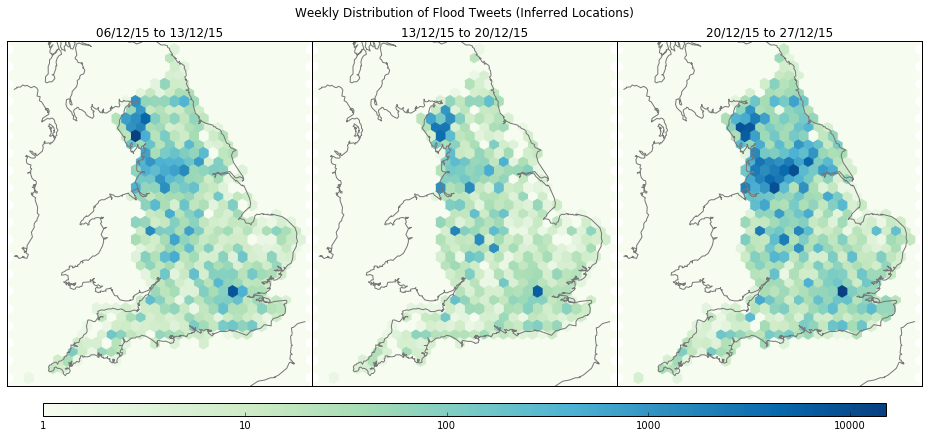

In [108]:
from mpl_toolkits.basemap import Basemap
# plotting multiple
# 3 = figsize(15, 4)
figsize(13, 6)
f, axarr = plt.subplots(1, segs, sharey=True)

lnscale = matplotlib.colors.LogNorm(vmax=15000)

for bm_x in range(segs):
    bm_plt = axarr[bm_x]
    
    dformat = "%d/%m/%y"
    bm_plt.set_title(segmins[bm_x].strftime(dformat) + " to " + segmaxs[bm_x].strftime(dformat))
    
    bmp = Basemap(projection='merc', lat_0=53.458736, lon_0=-2.2,
        resolution='i', area_thresh = 1000.0,
        urcrnrlat=56, urcrnrlon=2,
        llcrnrlat=49.75, llcrnrlon=-6.75, ax=bm_plt) 
    
    xp = []
    yp = []
    cp = []
    for x in segevs[bm_x]:
        j = bmp(x['centre'][0], x['centre'][1])
        xp.append(j[0])
        yp.append(j[1])
        #cp.append(1/popmap.get_population(x['centre'][1], x['centre'][0]))

    #ax.set_title('Distribution of flood tweets')
    hb = bmp.hexbin(array(xp), array(yp), norm=lnscale, gridsize=(30, 20),
              extent=[c2[0], c1[0], c2[1], c1[1]], cmap='GnBu')#C=cp, reduce_C_function=sum)
    formatter = LogFormatter(10, labelOnlyBase=False) 
                
    bmp.drawcoastlines(color="#777777")
    #mp.drawcountries()
    #bmp.fillcontinents(color='#CCCCCC', zorder=0)
    bmp.drawmapboundary()
   
tight_layout()
subplots_adjust(wspace=0, hspace=0, bottom=0)

subplots_adjust(top=0.90, bottom=0.1)
cbar_ax = f.add_axes([0.05, 0.032, 0.9, 0.03])
f.colorbar(hb,orientation='horizontal', cax=cbar_ax, format=formatter)#
f.suptitle('Weekly Distribution of Flood Tweets (Inferred Locations)', fontsize=12)

plt.savefig('uk-tweets-weekly', dpi=200, alpha=True)

0

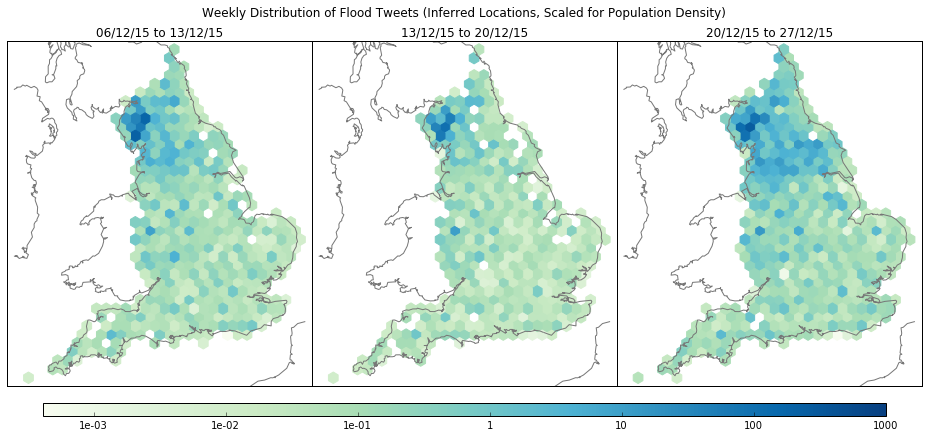

In [48]:
from mpl_toolkits.basemap import Basemap
# plotting multiple
# 3 = figsize(15, 4)
figsize(13, 6)
f, axarr = plt.subplots(1, segs, sharey=True)

lnscale = matplotlib.colors.LogNorm(vmax=1000)

off = 0
for bm_x in range(segs):
    bm_plt = axarr[bm_x]
    
    dformat = "%d/%m/%y"
    bm_plt.set_title(segmins[bm_x].strftime(dformat) + " to " + segmaxs[bm_x].strftime(dformat))
    
    bmp = Basemap(projection='merc', lat_0=53.458736, lon_0=-2.2,
        resolution='i', area_thresh = 1000.0,
        urcrnrlat=56, urcrnrlon=2,
        llcrnrlat=49.75, llcrnrlon=-6.75, ax=bm_plt) 
    
    xp = []
    yp = []
    cp = []
    for x in segevs[bm_x]:
        j = bmp(x['centre'][0], x['centre'][1])
        xp.append(j[0])
        yp.append(j[1])
        
        pop = popmap.get_population(x['centre'][1], x['centre'][0])
        cp.append(1/pop if pop != -9999 else 1/1000)

    #ax.set_title('Distribution of flood tweets')
    hb = bmp.hexbin(array(xp), array(yp), norm=lnscale, gridsize=(30, 20),
              extent=[c2[0], c1[0], c2[1], c1[1]], cmap='GnBu', C=cp, reduce_C_function=sum)#lambda x:len(x)/mean(x))#sum)
    formatter = LogFormatter(10, labelOnlyBase=False) 
                
    bmp.drawcoastlines(color="#777777")
    #mp.drawcountries()
    #bmp.fillcontinents(color='#CCCCCC', zorder=0)
    bmp.drawmapboundary()
   
tight_layout()
subplots_adjust(wspace=0, hspace=0, bottom=0)

subplots_adjust(top=0.90, bottom=0.1)
cbar_ax = f.add_axes([0.05, 0.032, 0.9, 0.03])
f.colorbar(hb,orientation='horizontal', cax=cbar_ax, format=formatter)#
f.suptitle('Weekly Distribution of Flood Tweets (Inferred Locations, Scaled for Population Density)', fontsize=12)

plt.savefig('uk-tweets-weekly-popscaled', dpi=200, alpha=True)
off

In [42]:
min(cp)

16.22513

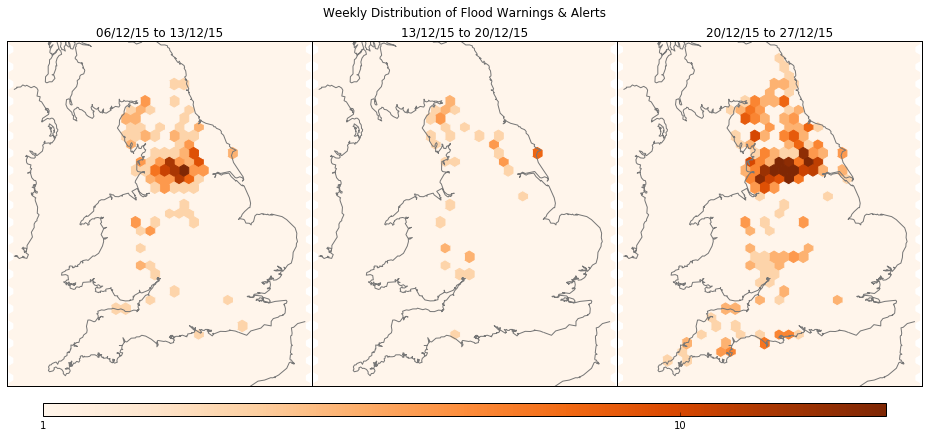

In [93]:
from mpl_toolkits.basemap import Basemap
# plotting multiple
# 3 = figsize(15, 4)
figsize(13, 6)
f, axarr = plt.subplots(1, segs, sharey=True)

lnscale = matplotlib.colors.LogNorm()

for bm_x in range(segs):
    bm_plt = axarr[bm_x]
    
    dformat = "%d/%m/%y"
    bm_plt.set_title(segmins[bm_x].strftime(dformat) + " to " + segmaxs[bm_x].strftime(dformat))
    
    bmp = Basemap(projection='merc', lat_0=53.458736, lon_0=-2.2,
        resolution='i', area_thresh = 1000.0,
        urcrnrlat=56, urcrnrlon=2,
        llcrnrlat=49.75, llcrnrlon=-6.75, ax=bm_plt) 
    
    xp = []
    yp = []
    cp = []
    for x in floods:
        if x['starttime'] <= segmins[bm_x] or x['starttime'] > segmaxs[bm_x]:
            continue
        try:
            x2,y = bmp(x['coordinates'][0], x['coordinates'][1])
        except KeyError:
            continue
            
        xp.append(x2)
        yp.append(y)
        
    #ax.set_title('Distribution of flood tweets')
    hb = bmp.hexbin(array(xp), array(yp), norm=lnscale, gridsize=(30, 20),
              extent=[c2[0], c1[0], c2[1], c1[1]], cmap='Oranges')#C=cp, reduce_C_function=sum)
    formatter = LogFormatter(10, labelOnlyBase=False) 
        
    bmp.drawcoastlines(color="#777777")
    #mp.drawcountries()
    #bmp.fillcontinents(color='#CCCCCC', zorder=0)
    bmp.drawmapboundary()
   
tight_layout()
subplots_adjust(wspace=0, hspace=0, bottom=0)

subplots_adjust(top=0.90, bottom=0.1)
cbar_ax = f.add_axes([0.05, 0.032, 0.9, 0.03])
f.colorbar(hb, orientation='horizontal', cax=cbar_ax, format=formatter)#
f.suptitle('Weekly Distribution of Flood Warnings', fontsize=12)

plt.savefig('uk-warnings-weekly', dpi=200, alpha=True)

In [25]:
docs[0].keys()

dict_keys(['centres', 'times', 'tweets'])

In [14]:
import datetime 

startday = 12 # 11 alright

segs2 = 3
segmins2 = [
    datetime.datetime(year=2015, month=12, day=startday),
    datetime.datetime(year=2015, month=12, day=startday + 7),
    datetime.datetime(year=2015, month=12, day=startday + 14)
]
segmaxs2 = [d + datetime.timedelta(days=1) for d in segmins2]

segevs2 = []
for d in range(segs2):
    segevs2.append([])
    for x in docs_bd_uk:
        if (x['times']['start'] >= segmins2[d] and x['times']['start'] < segmaxs2[d]) or \
            (x['times']['start'] >= segmins2[d] and x['times']['start'] < segmaxs2[d]):
            segevs2[d].append(x)

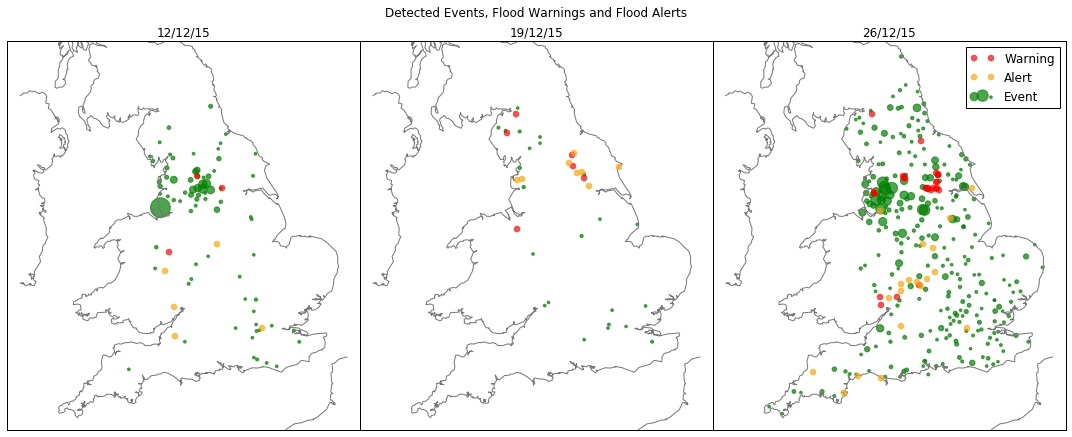

In [15]:
from mpl_toolkits.basemap import Basemap
figsize(15, 6)
f, axarr = plt.subplots(1, segs2, sharey=True)

lnscale = matplotlib.colors.LogNorm()

for bm_x in range(segs2):
    bm_plt = axarr[bm_x]
    
    dformat = "%d/%m/%y"
    bm_plt.set_title(segmins2[bm_x].strftime(dformat))
    
    bmp = Basemap(projection='merc', lat_0=53.458736, lon_0=-2.2,
        resolution='i', area_thresh = 1000.0,
        urcrnrlat=56, urcrnrlon=2,
        llcrnrlat=49.75, llcrnrlon=-6.75, ax=bm_plt) 

    wx = []
    wy = []
    ax = []
    ay = []
    for x in floods:
        if x['starttime'] <= segmins2[bm_x] or x['starttime'] > segmaxs2[bm_x]:
            continue
        try:
            x2,y = bmp(x['coordinates'][0], x['coordinates'][1])
        except KeyError:
            continue

        if 'Alert' in x['alert']:
            ax.append(x2)
            ay.append(y)
        else:
            wx.append(x2)
            wy.append(y)
    
    bmp.plot(wx, wy, '.', markersize=12, color='red', alpha=0.7, label='Warning')
    bmp.plot(ax, ay, '.', markersize=12, color='orange', alpha=0.7, label='Alert')

    px = []
    py = []
    ms = []
    for x in segevs2[bm_x]:
        for p in x['centres']:
            if p is None: 
                continue

            #if len(x['tweets']) < 50:
            #   continue

            x2,y = bmp(p[1], p[0])
            ms.append(25 + len(x['tweets']) ** 1/2)
            px.append(x2)
            py.append(y)
            
    bmp.scatter(px, py, s=ms, marker='.', color='green', alpha=0.7, label='Event')

    bmp.drawcoastlines(color="#777777")
    #mp.drawcountries()
    #bmp.fillcontinents(color='#CCCCCC', zorder=0)
    bmp.drawmapboundary()
  
tight_layout()
subplots_adjust(wspace=0, hspace=0, bottom=0, top=0.9)
legend()
suptitle('Detected Events, Flood Warnings and Flood Alerts', fontsize=12)  

plt.savefig('uk-event-days', dpi=200, alpha=True)

In [16]:
fwauk_alerts = [a for a in flood_warnings_all_uk if 'Alert' in a['alert']]
fwauk_warnings = [a for a in flood_warnings_all_uk if 'Warning' in a['alert']]

len(flood_warnings_all_uk), len(fwauk_alerts), len(fwauk_warnings)

(794, 314, 480)

In [77]:
import datetime
from geopy.distance import vincenty

closeness = 10
res = []
for t in [0, 25, 50, 100, 250, 500, 1000, 5000]:
    close_warnings = {}
    close_alerts = {}
    test_distances = []
    count_no_alerts = 0
    noalerts = []
    count = 0
    
    # loop through all UK events
    for i, x in enumerate(docs_bd_uk):
        # if the event has too little tweets, skip
        if len(x['tweets']) < t:
            continue
        
        count += 1
        closed = False

        day = x['times']['start'].day
        warnings = []
        while day <= x['times']['finish'].day:
            td = datetime.datetime(year=x['times']['start'].year, month=x['times']['start'].month, day=day)
            warnings += windows[str(td)]
            day += 1

        dises = [] 
        for w in warnings:
            for p in x['centres']:
                dis = vincenty((w['coordinates'][1], w['coordinates'][0]), (p[0], p[1])).km
                dises.append(dis)

            if dis < closeness:
                closed = True
                key = str(w['starttime']) + "--" + w['code']
                if 'Alert' in w['alert']:
                    close_alerts[key] = 1
                else:
                    close_warnings[key] = 1

        if not closed:
            count_no_alerts += 1
            noalerts.append(x)
                    
        mindis = min(dises)
        test_distances.append(mindis) 
        
    res.append([t, count, len(close_alerts), len(close_warnings), mean(test_distances), count_no_alerts])
res

[[0, 964, 120, 371, 73.049563715830729, 772],
 [25, 396, 90, 342, 39.689032739520769, 263],
 [50, 252, 73, 330, 27.743539167238215, 149],
 [100, 153, 62, 311, 20.835909545157712, 72],
 [250, 81, 49, 265, 11.373995679952818, 26],
 [500, 43, 38, 188, 7.9836714203353232, 9],
 [1000, 22, 25, 118, 7.7302832671790354, 5]]

In [86]:
naid = 3
noalerts[naid]['centres'], random.choice([a['id'] for a in noalerts[naid]['tweets']], 5)

([[52.55555555555567, -1.9444444444444442],
  [52.49999999998857, -1.9074074074070564]],
 array([ObjectId('5679a53aed60b543ba4e1d6a'),
        ObjectId('5676cb93ed60b543ba4ced70'),
        ObjectId('56705ef8ed60b543ba4a732d'),
        ObjectId('5669dcaaed60b543ba4673d3'),
        ObjectId('567f919ded60b543ba5416ec')], dtype=object))

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=1087890.2650162876,5936456.2896320885,1205393.050084058,6000235.93555988&bboxSR=5520&imageSR=5520&size=1500,814&dpi=96&format=png32&f=image


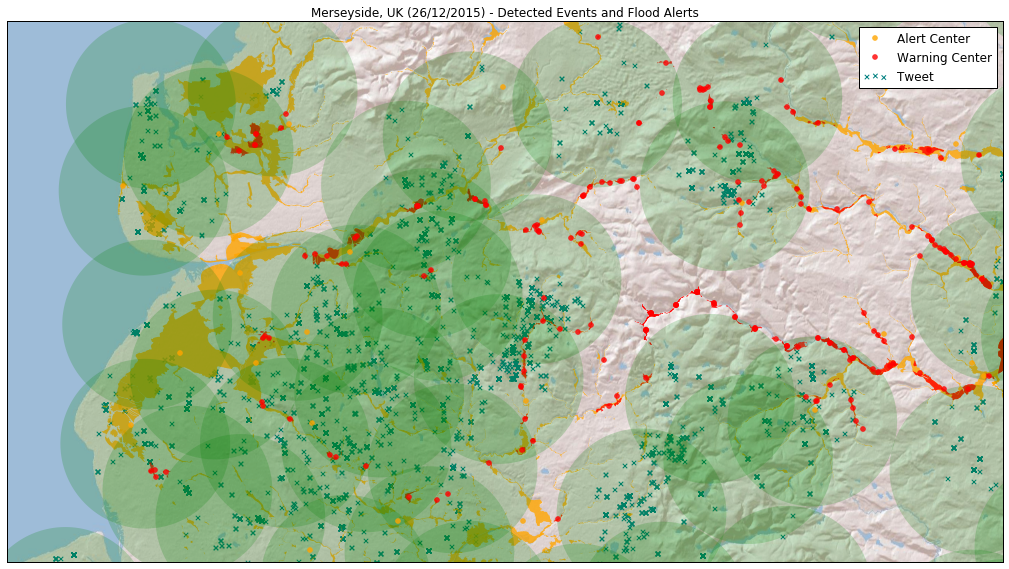

In [117]:
from mpl_toolkits.basemap import Basemap
from Circles.circles import circle
from matplotlib.patches import Polygon as mplPolygon

figsize(16, 8)

#dformat = "%d/%m/%y"
#set_title(segmins2[bm_x].strftime(dformat))

bmp = Basemap(projection='merc', lat_0=53.458736, lon_0=-2.2,
    resolution='h', area_thresh = 1000.0,
    urcrnrlat=54.05, urcrnrlon=-1.5,
    llcrnrlat=53.4, llcrnrlon=-3.2, epsg=5520)

dmin = datetime.datetime(year=2015, month=12, day=26)
dmax = datetime.datetime(year=2015, month=12, day=27)

wx = []
wy = []
ax = []
ay = []
for x in floods:
    if x['starttime'] <= dmin - datetime.timedelta(days=2) or x['starttime'] >= dmax:
        continue
        
    try:
        x2,y = bmp(x['coordinates'][0], x['coordinates'][1])
    except KeyError:
        continue

    if 'Alert' in x['alert']:
        ax.append(x2)
        ay.append(y)
    else:
        wx.append(x2)
        wy.append(y)
        
    geodat = eval(x['geometry_data'])
    
    if x['geometry_type'] != 'MultiPolygon':
        geodat = [geodat]
        
    for o1 in geodat:
        for o2 in o1:
            xy = []
            for i in o2:
                xy.append(bmp(i[0], i[1]))
                
            col = 'red' if 'Warning' in x['alert'] else 'orange'
            poly = mplPolygon(xy, facecolor='red' if 'Warning' in x['alert'] else 'orange', alpha=0.8, linewidth=0)
            plt.gca().add_patch(poly)

bmp.plot(ax, ay, '.', markersize=10, color='orange', label='Alert Center', alpha=0.8)
bmp.plot(wx, wy, '.', markersize=10, color='red', label='Warning Center', alpha=0.8)

px = []
py = []
for x in docs_bd_uk:
    if not ((x['times']['start'] >= dmin and x['times']['start'] < dmax) or \
        (x['times']['start'] >= dmin and x['times']['start'] < dmax)):
            continue
                
    for p in x['centres']:
        if p is None: 
            continue

        x2,y = bmp(p[1], p[0])
        casa = circle(bmp, p[1], p[0], 10)
        pol = mplPolygon([c for c in casa], facecolor='green', alpha=0.2, linewidth=0)
        plt.gca().add_patch(pol)
        
    for p in x['tweets']:
        x2, y = bmp(p['coordinate'][1], p['coordinate'][0])
        px.append(x2)
        py.append(y)
        
bmp.scatter(px, py, marker='x', color='teal', label='Tweet')

#bmp.drawcoastlines(color="#777777")
#mp.drawcountries()
#bmp.fillcontinents(color='#CCCCCC', zorder=0)
bmp.drawmapboundary()
#bmp.shadedrelief()
bmp.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True) # Elevation/World_Hillshade
#bmp.drawrivers(color='#0000ff')

legend(numpoints=1)
title('Merseyside, UK (26/12/2015) - Detected Events and Flood Alerts')
tight_layout()
plt.savefig('uk-zoom-day2', dpi=200, alpha=True)

In [232]:
# Find events within area

cc1 = (54.05, -1.5)
cc2 = (53.4, -3.2)

lamin, lamax, lomin, lomax = min([cc1[0], cc2[0]]), max([cc1[0], cc2[0]]), min([cc1[1], cc2[1]]), max([cc1[1], cc2[1]])

cut_docs = []
for x in docs_bd_uk:
    for p in x['centres']:
        if p[0] > lamin and p[0] < lamax and p[1] > lomin and p[1] < lomax:
            cut_docs.append(x)
            break
len(cut_docs)

114

In [248]:
random.choice([x['id'] for x in cut_docs[85]['tweets']], 30)

array([ObjectId('567e8773ed60b543ba515bed'),
       ObjectId('567e97d5ed60b543ba5193ab'),
       ObjectId('567db4a5ed60b543ba505bb6'),
       ObjectId('567e9e2fed60b543ba51a8fa'),
       ObjectId('567e8237ed60b543ba514b4a'),
       ObjectId('567f1556ed60b543ba5334b0'),
       ObjectId('567e8844ed60b543ba515ee2'),
       ObjectId('567e853fed60b543ba515470'),
       ObjectId('567f1baced60b543ba534cc1'),
       ObjectId('567e9b92ed60b543ba51a025'),
       ObjectId('567dc148ed60b543ba5067bd'),
       ObjectId('567ea72bed60b543ba51c549'),
       ObjectId('567e9ea0ed60b543ba51aa73'),
       ObjectId('567e8b3eed60b543ba5169ba'),
       ObjectId('567eebb8ed60b543ba529f37'),
       ObjectId('567e72bced60b543ba511f80'),
       ObjectId('567e5a3fed60b543ba50e559'),
       ObjectId('567e99e3ed60b543ba519a5f'),
       ObjectId('567e9823ed60b543ba5194b9'),
       ObjectId('567ea8f5ed60b543ba51cac0'),
       ObjectId('567eb04eed60b543ba51e1f6'),
       ObjectId('567ed038ed60b543ba524a92'),
       Obj

In [166]:
floods[0]['geometry_type']

'MultiPolygon'

In [ ]:

wx = []
wy = []
ax = []
ay = []
for x in floods:
    if x['starttime'] <= tmin or x['starttime'] > tmax:
        continue
    try:
        x2,y = bmp(x['coordinates'][0], x['coordinates'][1])
    except KeyError:
        continue

    if 'Alert' in x['alert']:
        ax.append(x2)
        ay.append(y)
    else:
        wx.append(x2)
        wy.append(y)

bmp.plot(wx, wy, '.', markersize=5, color='orange', alpha=0.7, label='Warning')
bmp.plot(ax, ay, '.', markersize=5, color='red', alpha=0.7, label='Alert')

px = []
py = []
ms = []
for x in docs_geo_bd_uk:
    for p in x['centres']:
        if p is None: 
            continue

        if len(x['tweets']) < [0, 100, 500][bm_x]:
            continue

        x2,y = bmp(p[1], p[0])
        ms.append(25)#len(x['tweets']))
        px.append(x2)
        py.append(y)
bmp.scatter(px, py, s=ms, marker='.', color='green', alpha=0.7, label='Event')

In [48]:
from geopy.distance import vincenty

event_distances = []
event_distances25 = []
event_distances100 = []
for i, x in enumerate(docs_bd_uk):
    p = x['centres'][0]
    
    day = x['times']['start'].day
    warnings = []
    while day <= x['times']['finish'].day:
        td = datetime.datetime(year=x['times']['start'].year, month=x['times']['start'].month, day=day)
        warnings += windows[str(td)]
        day += 1

    mindis = min([vincenty((w['coordinates'][1], w['coordinates'][0]), (p[0], p[1])).km for w in warnings])
    event_distances.append(mindis) 
    
    if len(x['tweets']) > 25:
        event_distances25.append(mindis)     
    if len(x['tweets']) > 100:
        event_distances100.append(mindis) 
        
event_distances_geo = []
for i, x in enumerate(docs_geo_bd_uk):
    p = x['centres'][0]
    
    day = x['times']['start'].day
    warnings = []
    while day <= x['times']['finish'].day:
        td = datetime.datetime(year=x['times']['start'].year, month=x['times']['start'].month, day=day)
        warnings += windows[str(td)]
        day += 1

    mindis = min([vincenty((w['coordinates'][1], w['coordinates'][0]), (p[0], p[1])).km for w in warnings])
    event_distances_geo.append(mindis) 

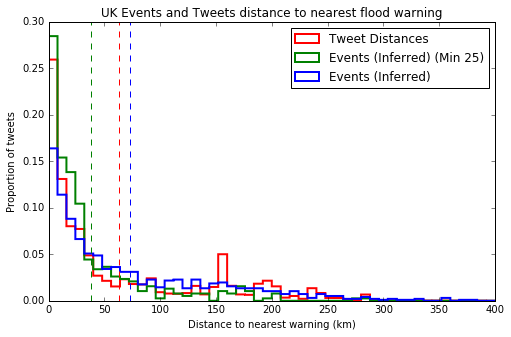

In [111]:
figsize(8, 5)

weights = np.ones_like(event_distances) / len(event_distances)
weights4 = np.ones_like(event_distances25) / len(event_distances25)
weights5 = np.ones_like(distances) / len(distances)

a = hist([event_distances, event_distances25, distances],  histtype='step', bins=50, range=[0, 400],
         label=["Events (Inferred)", "Events (Inferred) (Min 25)", "Tweet Distances"], 
         linewidth=2, weights=[weights, weights4, weights5])

axvline(x=mean(event_distances), linestyle='dashed', color='b')
axvline(x=mean(event_distances25), linestyle='dashed', color='g')
axvline(x=mean(distances), linestyle='dashed', color='r')

figsize(8, 5)
legend()
xlabel('Distance to nearest warning (km)')
ylabel('Proportion of tweets')
title('UK Events and Tweets distance to nearest flood warning')
savefig('uk-event-dis-all', dpi=200)

In [252]:
docs_geo_bd_uk[0]

{'centres': [[54.921142, -2.858227]],
 'times': {'finish': datetime.datetime(2015, 12, 8, 21, 35, 7, 875000),
  'start': datetime.datetime(2015, 12, 8, 16, 5, 32, 493000)},
 'tweets': [{'coordinate': [54.900832, -2.945482],
   'id': ObjectId('5666ffc6ed60b543ba437888'),
   'time': datetime.datetime(2015, 12, 8, 16, 5, 32, 493000)},
  {'coordinate': [54.900832, -2.945482],
   'id': ObjectId('5666ffc6ed60b543ba437888'),
   'time': datetime.datetime(2015, 12, 8, 16, 5, 32, 493000)},
  {'coordinate': [54.900832, -2.945482],
   'id': ObjectId('5666ffc6ed60b543ba437888'),
   'time': datetime.datetime(2015, 12, 8, 16, 5, 32, 493000)},
  {'coordinate': [54.900832, -2.945482],
   'id': ObjectId('5666ffc6ed60b543ba437888'),
   'time': datetime.datetime(2015, 12, 8, 16, 5, 32, 493000)},
  {'coordinate': [54.921142, -2.858227],
   'id': ObjectId('566706aeed60b543ba43851b'),
   'time': datetime.datetime(2015, 12, 8, 16, 35, 0, 371000)},
  {'coordinate': [54.89334555, -2.91817234],
   'id': ObjectId

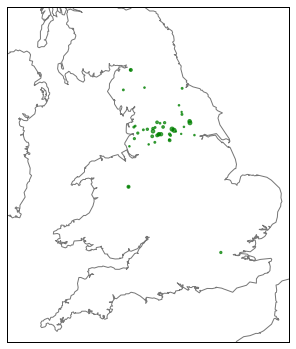

In [262]:
with open('D:/ds/code/implementation/real2.pkl', 'rb') as file:
    docs_geo2 = pickle.load(file)

bmp = Basemap(projection='merc', lat_0=53.458736, lon_0=-2.2,
    resolution='i', area_thresh = 1000.0,
    urcrnrlat=56, urcrnrlon=2,
    llcrnrlat=49.75, llcrnrlon=-6.75) 

px = []
py = []
ms = []
for x in docs_geo2:
    for p in x['centres']:
        if p is None: 
            continue

        #if len(x['tweets']) < 50:
        #   continue

        x2,y = bmp(p[1], p[0])
        ms.append(5 + len(x['tweets']) ** 1/2)
        px.append(x2)
        py.append(y)

bmp.scatter(px, py, s=ms, marker='.', color='green', alpha=0.7, label='Event')

bmp.drawcoastlines(color="#777777")
bmp.drawmapboundary()

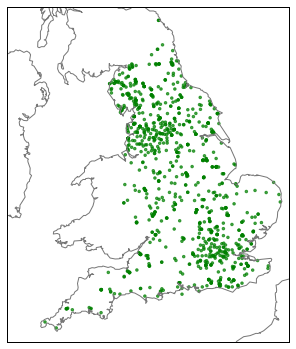

In [268]:
with open('D:/ds/code/implementation/allevents_uk2.pkl', 'rb') as file:
    docs_allevents_uk = pickle.load(file)

bmp = Basemap(projection='merc', lat_0=53.458736, lon_0=-2.2,
    resolution='i', area_thresh = 1000.0,
    urcrnrlat=56, urcrnrlon=2,
    llcrnrlat=49.75, llcrnrlon=-6.75) 

px = []
py = []
ms = []
for x in docs_allevents_uk:
    for p in x['centres']:
        if p is None: 
            continue

        #if len(x['tweets']) < 50:
        #   continue

        x2,y = bmp(p[1], p[0])
        ms.append(25)# + len(x['tweets']) ** 1/2)
        px.append(x2)
        py.append(y)

bmp.scatter(px, py, s=ms, marker='.', color='green', alpha=0.7, label='Event')

bmp.drawcoastlines(color="#777777")
bmp.drawmapboundary()

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=812381.8597089569,5556401.007668588,1450092.5239025892,6208207.53850199&bboxSR=5520&imageSR=5520&size=1500,1533&dpi=96&format=png32&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=812381.8597089569,5556401.007668588,1450092.5239025892,6208207.53850199&bboxSR=5520&imageSR=5520&size=1500,1533&dpi=96&format=png32&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=812381.8597089569,5556401.007668588,1450092.5239025892,6208207.53850199&bboxSR=5520&imageSR=5520&size=1500,1533&dpi=96&format=png32&f=image


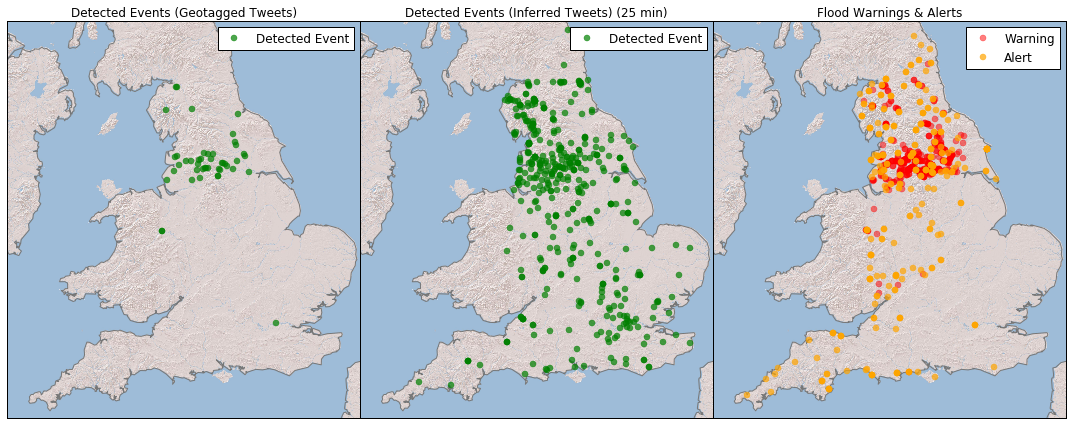

In [44]:
from mpl_toolkits.basemap import Basemap
figsize(15, 6)
f, axarr = plt.subplots(1, 3, sharey=True)

lnscale = matplotlib.colors.LogNorm()

for bm_x in range(3):
    bm_plt = axarr[bm_x]
    
    dformat = "%d/%m/%y"
    bm_plt.set_title(["Detected Events (Geotagged Tweets)", "Detected Events (Inferred Tweets) (25 min)", "Flood Warnings & Alerts"][bm_x])
    
    bmp = Basemap(projection='merc', lat_0=53.458736, lon_0=-2.2,
        resolution='i', area_thresh = 1000.0,
        urcrnrlat=56, urcrnrlon=2.2,
        llcrnrlat=49.75, llcrnrlon=-6.55, ax=bm_plt, epsg=5520)

    if bm_x == 2:
        wx = []
        wy = []
        ax = []
        ay = []
        for x in floods:
            if x['starttime'] <= tmin or x['starttime'] > tmax:
                continue
            try:
                x2,y = bmp(x['coordinates'][0], x['coordinates'][1])
            except KeyError:
                continue

            if 'Alert' in x['alert']:
                ax.append(x2)
                ay.append(y)
            else:
                wx.append(x2)
                wy.append(y)

        bmp.plot(wx, wy, '.', markersize=12, color='red', alpha=0.5, label='Warning')
        bmp.plot(ax, ay, '.', markersize=12, color='orange', alpha=0.7, label='Alert')
        bm_plt.legend(numpoints=1)
    else:
        px = []
        py = []
        ms = []
        for x in (docs_bd_uk if bm_x == 1 else docs_geo_bd_uk):
            for p in x['centres']:
                if p is None: 
                    continue

                if bm_x == 1 and len(x['tweets']) < 25:
                    continue

                x2,y = bmp(p[1], p[0])
                ms.append(12 ** 2)# + len(x['tweets']) ** 1/20)
                px.append(x2)
                py.append(y)

        bmp.plot(px, py, '.', markersize=12, color='green', alpha=0.7, label='Detected Event')
        bm_plt.legend(numpoints=1)

    bmp.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True) # Elevation/World_Hillshade
    bmp.drawcoastlines(color="#777777")
    #mp.drawcountries()
    #bmp.fillcontinents(color='#CCCCCC', zorder=0)
    bmp.drawmapboundary()
  
tight_layout()
subplots_adjust(wspace=0, hspace=0)
#suptitle('Detected Events, Flood Warnings and Flood Alerts', fontsize=12)  

plt.savefig('uk-event-comparison', dpi=200, alpha=True)

In [115]:
max([len(a['tweets']) for a in docs_geo_bd_uk]), min([len(a['tweets']) for a in docs_geo_bd_uk])
#docs_geo_bd_uk

(124, 6)